In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
from collections import deque
from skimage.transform import resize
import sklearn.cluster
from skimage import draw


import snake_functions as sf
#import importlib
#importlib.reload(sf)

In [2]:
class deform_model():
    def __init__(self,n_points, center, radius, smooth_param):
        th = np.arange(0,1,1/n_points)*(2*np.pi)
        self.snake = np.array([np.cos(th), np.sin(th)]).transpose()*radius + center
        self.normals = self.compute_normals()
        self.smooth_mat = sf.smooth_matrix(n_points, smooth_param[0], smooth_param[1])

    def compute_normals(self):
        a = np.zeros_like(self.snake)
        s_prev = np.roll(self.snake,  1, axis=0) # prev
        s_next = np.roll(self.snake, -1, axis=0) # next
        a[:,0] =   s_next[:,1] - s_prev[:,1]
        a[:,1] = -(s_next[:,0] - s_prev[:,0])
        a = a / np.linalg.norm(a, axis=1)[:,None]
        return a
    
    def read_values(self,img):
        idx_xy = self.snake.astype(int)
        return (img[idx_xy[:,0], idx_xy[:,1]])

    def set_forces(self, forces):
        self.force_vecs = forces[:,None] * self.normals
        
    def update(self, step_size, img_shape):
        self.snake += self.force_vecs*step_size
        self.regularize()
        # Prevent exceeding image boundaries:
        np.clip(model.snake[:,0], 0, img_shape[0]-1, out=model.snake[:,0])
        np.clip(model.snake[:,1], 0, img_shape[1]-1, out=model.snake[:,1])
        self.normals = self.compute_normals()
        
    def regularize(self):
        self.snake[:,:] = self.smooth_mat.dot(self.snake)
        snakeT = sf.distribute_points(self.snake.T)
        snakeT = sf.remove_intersections(snakeT)
        self.snake[:,:] = snakeT.T


In [56]:
def create_prob_image(img, mask, filter_size=10, return_probs=False):    
    all_unique = np.unique(img.flatten()) # array containing each different pixel value

    count_inside = np.zeros_like(all_unique)
    count_outside = np.zeros_like(all_unique)
    count_total = np.zeros_like(all_unique)
    for i,x in enumerate(all_unique):
        count_inside[i] = (img[mask]==x).sum()
        count_outside[i] = (img[~mask]==x).sum()
        count_total[i] = count_inside[i]+count_outside[i]
        
    omega_in = mask.sum()
    omega_out = img.size - omega_in
#    pixel_prc_in = count_inside/total_inside
#    pixel_prc_out = count_outside/total_outside
#    pixel_probs = pixel_prc_in / (pixel_prc_in+pixel_prc_out)
    
    pixel_probs = count_inside/(count_outside+1e-8)
    
    prob_img = np.zeros_like(img, dtype=float)
    for i,x in enumerate(all_unique):
        prob_img[img==x] = pixel_probs[i]
#    prob_img = ndimage.gaussian_filter(prob_img, sigma=(5, 5), order=0)
    prob_img = ndimage.median_filter(prob_img, size=filter_size)

    if return_probs: 
        return prob_img, omega_in, omega_out, pixel_probs
    else:
        return prob_img, omega_in, omega_out

In [4]:
def colorize_prob_img(prob_img, channels=(1,0)):
    prob_img_color = np.zeros(prob_img.shape+(3,), dtype='uint8')
    prob_img_color[:,:,channels[0]] =  prob_img*(prob_img > 0) * 255
    prob_img_color[:,:,channels[1]] = -prob_img*(prob_img < 0) * 255
    return prob_img_color

In [5]:
def layout_dictionary(cluster_centers, rows, cols, patch_shape=(), color=False, highlight=None, spacing=3):
    if(patch_shape==()):
        s = int(np.sqrt(cluster_centers.shape[1]/(1+2*color)))
        patch_shape = (s,s)

    h = patch_shape[0]+spacing
    w = patch_shape[1]+spacing
    dict_img = np.zeros((rows*w + spacing, cols*w + spacing, 3), dtype='uint8')

    if(color):
        cluster_centers = cluster_centers.reshape(rows,cols,3,patch_shape[0],patch_shape[1])
        cluster_centers = np.moveaxis(cluster_centers, -3, -1) # move color axis to last dim, (r,c,3,ps,ps) -> (r,c,ps,ps,3)
    else:
        cluster_centers = cluster_centers.reshape(rows,cols,patch_shape[0],patch_shape[1])

    if(highlight is not None): highlight = highlight.reshape(rows,cols)

    for r in range(rows):
        for c in range(cols):
            y = spacing + r*h
            x = spacing + c*w
            if(highlight is not None):
                p = highlight[r,c]
                dict_img[y-1:y+patch_shape[0]+1, x-1:x+patch_shape[1]+1, :] = [-p*(p<0)*255, p*(p>0)*255, 0]
                
            if(color):
                dict_img[y:y+patch_shape[0], x:x+patch_shape[1], ] = cluster_centers[r,c,:,:,]
            else:
                dict_img[y:y+patch_shape[0], x:x+patch_shape[1], ] = cluster_centers[r,c,:,:,None]
    
    return dict_img

In [72]:
import cv2

def draw_snake(img_out, snake, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    pt0 = snake[-1,:].astype(int)
    for i in range(len(snake)):
        pt1 = snake[i,:].astype(int)
        img_out = cv2.line(img_out, tuple(pt0), tuple(pt1), color, 1)
        img_out = cv2.circle(img_out, tuple(pt1), 2, color, cv2.FILLED, 1)
        pt0 = pt1
    return img_out 

def draw_forces(img_out, snake, forces, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    forces = np.flip(forces,axis=1)
    for i in range(len(snake)):
        pt = snake[i,:]
        pt2 = snake[i,:] + forces[i,]
        img_out = cv2.arrowedLine(img_out, tuple(pt.astype(int)), tuple(pt2.astype(int)), color, 1)
    return img_out 

def vis_snake(img, snake, forces={}, wait=30, color=(255,0,0), title="snake"):
    if img.ndim==2:
        img_out = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    else:
        img_out = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    img_out = draw_snake(img_out, snake, color)
    if len(forces)>0:
        img_out = draw_forces(img_out, snake, forces, color=color)
    cv2.imshow(title, img_out)
    key = cv2.waitKey(0)
    return key==27



In [7]:
def im2col(A, BSZ, stepsize=1):
    # Parameters
    m,n = A.shape
    s0, s1 = A.strides
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

def ndim2col(A, BSZ, stepsize=1):
    if(A.ndim == 2):
        return im2col(A, BSZ, stepsize)
    else:
        r,c,l = A.shape
        patches = np.zeros((l*BSZ[0]*BSZ[1],(r-BSZ[0]+1)*(c-BSZ[1]+1)))
        for i in range(l):
            patches[i*BSZ[0]*BSZ[1]:(i+1)*BSZ[0]*BSZ[1],:] = im2col(A[:,:,i],BSZ,stepsize)
        return patches

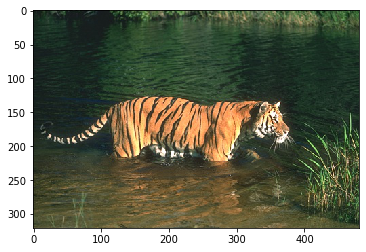

In [64]:
#fname = "data/12003.jpg" # seastar
#fname = "data/134052.jpg" #leopard
fname = "data/108073.jpg" # tiger

img = plt.imread(fname)
plt.imshow(img)

In [65]:

E = 2
K = 1+2*E # <- patch size
samp_size = 10000
clusters = 200

snake_center = (150,150)
snake_radius = 70
num_points = 300

alpha = 0.05
beta = 0.1

step_size = 2

(151209, 75)


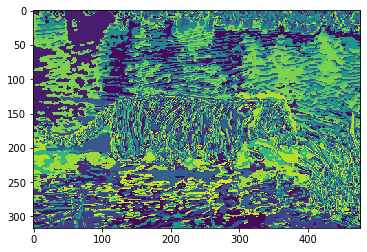

In [68]:

patch_size = (K,K)
features = ndim2col(img, patch_size).transpose()
print(features.shape)

sample_idx = np.random.permutation(features.shape[0])[:samp_size]
feature_sample = features[sample_idx,:]
kmeans = sklearn.cluster.KMeans(n_clusters=clusters, verbose=False).fit(feature_sample)

predicted_clusters = kmeans.predict(features)
cluster_img = predicted_clusters.reshape(img.shape[0]-2*E, img.shape[1]-2*E)
img = img[E:-E, E:-E] # crop image to match shapes
plt.imshow(cluster_img)

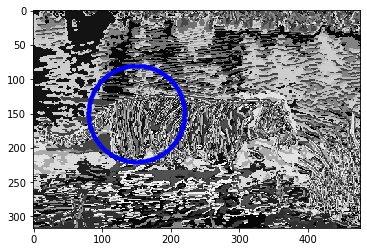

In [69]:
#model = deform_model(n_points = 140, center = (125,250), radius = 20, smooth_param=(0.05,0.1)) # start
#model = deform_model(n_points = 140, center = (125,250), radius = 20, smooth_param=(0.05,0.1)) # start

model = deform_model(n_points=num_points, center=snake_center, radius=snake_radius, smooth_param=(alpha,beta))

def plot_snake(snake,col='blue'):
    plt.plot(*zip(*np.flip(snake,axis=1)),'.-',linewidth=1,color=col)

plt.imshow(cluster_img, cmap='gray')
plot_snake(model.snake)

In [73]:

i = 0
while(True):
    if(i%1==0):
        mask = draw.polygon2mask(cluster_img.shape[:2], model.snake)
        prob_img, omega_in, omega_out, probs = create_prob_image(cluster_img, mask, filter_size=10, return_probs=True)
        prob_img_color = colorize_prob_img(prob_img-0.5, channels=(1,2))
        
        dict_img = layout_dictionary(kmeans.cluster_centers_, 10,20, color=True, highlight=probs-0.5)
        dict_img = ndimage.zoom(dict_img, (3, 3, 1), order=0)
        dict_img = cv2.cvtColor(dict_img,cv2.COLOR_RGB2BGR)

#    model.set_forces(model.read_values(prob_img) - 0.5)
    model.set_forces(np.log(omega_out/omega_in * model.read_values(prob_img)+1e-8))
    
    # Visualize
#    cv2.imshow("mask", mask.astype(float))
    cv2.imshow("color probs", prob_img_color)
    cv2.imshow("dictionary",dict_img)
#    vis_snake(prob_img.astype('float32'), model.snake, 3*step_size*model.force_vecs, wait=1, title="Probability")
    
    if vis_snake(img, model.snake, wait=30, title="Original"):
        break
    
    model.update(step_size, img.shape)
    i+=1
    
cv2.destroyAllWindows()
cv2.waitKey(1);